<a href="https://colab.research.google.com/github/falseywinchnet/EpistemicGPT/blob/main/Reasoning_Able_Pretrained_Engine_(RAPE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class LELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = math.pi / math.sqrt(3.0)

    def forward(self, x):
        return x * torch.sigmoid(self.scale * x)

class RoPE(nn.Module):
    def __init__(self, dim, max_len=4096):
        super().__init__()
        assert dim % 2 == 0
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, *, T, D)
        T = x.shape[-2]
        cos = self.cos[:T, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:T, :].unsqueeze(0).unsqueeze(0)

        # Adjust shapes for broadcasting if x has extra dims (like n_branch)
        while cos.ndim < x.ndim:
            cos = cos.unsqueeze(0)
            sin = sin.unsqueeze(0)

        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        y1 = x1 * cos - x2 * sin
        y2 = x1 * sin + x2 * cos
        return torch.stack((y1, y2), dim=-1).flatten(-2)

class InertialManifold(nn.Module):
    def __init__(
        self,
        config,
        palette_size: int = 16,     # H, W of the manifold
        kernel_size: int = 15,      # Bandwidth of the inertial filter
        expansion_factor: int = 2,  # Expansion for the output mixing
    ):
        super().__init__()
        self.d = config.n_embd
        self.h_pal = palette_size
        self.w_pal = palette_size
        self.history_dropout = getattr(config, 'history_dropout', 0.1) # Probability to drop a time-step

        # 1. The Territory (Palette)
        self.palette = nn.Parameter(
            torch.randn(1, config.n_embd, palette_size, palette_size) * (config.n_embd ** -0.5)
        )

        # 2. The Inertial Filter (Compass)
        self.norm = nn.LayerNorm(config.n_embd)
        self.inertial_conv = nn.Conv1d(
            in_channels=config.n_embd,
            out_channels=config.n_embd,
            kernel_size=kernel_size,
            padding=kernel_size - 1, # Causal padding
            groups=config.n_embd,    # Depthwise
            bias=False
        )

        # 3. The Navigator (now with Dropout)
        # Projects smoothed state -> (u, v) coordinates.
        self.navigator = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd // 2,bias=config.bias),
            LELU(),
            nn.Dropout(config.dropout), # Added Dropout
            nn.Linear(config.n_embd // 2, 2,bias=config.bias),
            nn.Tanh()
        )

        # 4. Integration (Output Projection) (now with Dropout)
        self.output_proj = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd * expansion_factor,bias=config.bias),
            LELU(),
            nn.Dropout(config.dropout), # Added Dropout
            nn.Linear(config.n_embd * expansion_factor, config.n_embd,bias=config.bias),
            nn.Dropout(config.dropout)  # Added Final Dropout
        )

        nn.init.dirac_(self.inertial_conv.weight)

    def forward(self, x):
        B, T, D = x.shape

        # --- A. Inertial Smoothing ---
        # Normalize
        # Epistemic Dropout: Drop Time-Steps (History Perforation)
        # We drop the input signal at random positions.
        # The Conv1d must use the kernel's momentum to bridge the gap.
        if self.training and self.history_dropout > 0:
            # Mask shape: (B, T, 1) -> Broadcasts across features
            mask = torch.bernoulli(torch.full((B, T, 1), 1.0 - self.history_dropout, device=x.device))
            x_ = x * (mask / (1.0 - self.history_dropout))
        else:
            x_ = x #pass through

        # Transpose for Conv1d: (B, T, D) -> (B, D, T)
        x_in = x_.transpose(1, 2)

        # Apply causal filter
        x_smooth = self.inertial_conv(x_in)[:, :, :T]
        x_smooth = x_smooth.transpose(1, 2)   # (B, T, D)

        # --- B. Navigation ---
        coords = self.navigator(x_smooth)
        grid = coords.view(B, 1, T, 2)

        # --- C. Territory Lookup ---
        batch_palette = self.palette.expand(B, -1, -1, -1)

        retrieved = F.grid_sample(
            batch_palette,
            grid,
            mode='bilinear',
            padding_mode='border',
            align_corners=True
        )

        retrieved = retrieved.squeeze(2).transpose(1, 2)

        # --- D. Integration ---
        y = self.output_proj(retrieved)

        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_branch = 4
        self.block_size = config.block_size
        self.history_dropout = getattr(config, 'history_dropout', 0.1) # Default 10%

        # Projections
        self.q_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.k_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.v_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Sinks
        self.v_sink_residual = nn.Parameter(torch.zeros(1, 1, 1, config.n_embd))
        self.v_sink_basis = nn.Parameter(torch.zeros(1, self.n_branch, 1, config.n_embd))

        # Register mask as non-persistent to fix the device mismatch bug
        self.register_buffer("mask", config.mask, persistent=False)

        self.rope = config.rope
        self.attn_drop = nn.Dropout(config.dropout)

    def forward(self, a, x):
        B, T, C = x.shape
        NB = self.n_branch
        device = x.device

        # 1. Projections
        q = self.q_proj(a).view(B, T, NB, C).transpose(1, 2)
        q = norm(q)
        v = self.v_proj(a).view(B, T, NB, C).transpose(1, 2)
        k = self.k_proj(x).view(B, T, 1, C).transpose(1, 2)

        # 2. RoPE
        q, k = self.rope(q), self.rope(k)

        # 3. Raw Scores
        att = (q @ k.transpose(-2, -1)) / math.sqrt(C)

        # 4. Masking Logic
        # A. Standard Causal Mask
        causal_mask = self.mask[:, :, :T, :T]
        att = att.masked_fill(causal_mask == 0, float("-inf"))

        # B. Stochastic History Dropout (Epistemic Perforation)
        # We drop random connections in the history (k < t)
        # but we MUST preserve the diagonal (k == t) so the Query isn't blinded.
        if self.training and self.history_dropout > 0:
            # 1. Generate random dropout mask (True = Drop)
            # Shape: (B, 1, T, T) - Broadcasts across branches
            drop_mask = torch.rand(B, 1, T, T, device=device) < self.history_dropout

            # 2. Enforce strict lower-triangularity (diagonal=-1)
            # This ensures the diagonal (current position) and upper triangle are False.
            drop_mask = drop_mask.tril(diagonal=-1)

            # 3. Apply drop
            att = att.masked_fill(drop_mask, float("-inf"))

        # 5. Branch Routing (Lazy Softmax Patch)
        # We replace the totalitarian F.softmax with a permissive normalization.
        # This allows the sum of branch probabilities to be < 1.0 (Lazy),
        # but prevents it from exceeding 1.0.

        # A. Activation (Softplus > Exp for stability and linearity)
        branch_scores = F.softplus(att)

        # B. Aggregation
        branch_sums = branch_scores.sum(dim=1, keepdim=True)

        # C. Lazy Normalization (Down to 1.0, never up)
        branch_scale = torch.clamp(1.0 / (branch_sums + 1e-6), max=1.0)
        soft_probs = branch_scores * branch_scale

        soft_probs = torch.nan_to_num(soft_probs, nan=0.0)

        # D. Hard Routing (Straight-Through Estimator)
        with torch.no_grad():
            max_val = soft_probs.max(dim=1, keepdim=True)[0]
            # If multiple branches are equal max, this picks all of them (multi-hot),
            # which is fine/good for equivalent hypotheses.
            hard_mask = (soft_probs == max_val).float()

        # The gradients flow through soft_probs, which now reflects the "Lazy" confidence.
        route_mask = (hard_mask - soft_probs).detach() + soft_probs

        # 6. Temporal Normalization
        scores_max, _ = att.max(dim=1)
        s = F.softplus(scores_max)
        S = s.sum(dim=-1, keepdim=True)
        scale = torch.clamp(1.0 / (S + 1e-6), max=1.0)

        w = s * scale
        w = self.attn_drop(w) # Standard dropout on weights still applies

        residual = 1.0 - w.sum(dim=-1, keepdim=True)

        # 7. Composition
        combined_weights = w.unsqueeze(1) * route_mask
        y_context = (combined_weights @ v)

        branch_activity = route_mask.max(dim=-1, keepdim=True)[0]
        y_basis = branch_activity * self.v_sink_basis

        y_branches = (y_context + y_basis).sum(dim=1)
        y_res = residual * self.v_sink_residual.squeeze(1)

        y = y_branches + y_res
        out = self.o_proj(y)
        return out


def norm(x):
    return F.rms_norm(x, (x.size(-1),))


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.think = InertialManifold(config)
        self.attn = Attention(config)
        self.mlp = MLP(config)
        self.mlp2 = MLP(config)


    def forward(self, x):
        B, T, C = x.shape
        q = self.think(norm(x))
        a = q + self.mlp(norm(q))
        u = x + self.attn(norm(a), norm(x))
        u = u + self.mlp2(norm(u)) #reconstructive shift
        steps = torch.arange(1, x.size(1) + 1, device=x.device).view(1, -1, 1)
        running_mean = torch.cumsum(norm(a), dim=1) / steps
        u = u + running_mean
        return u

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 1
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    n_branch: int = 4 # Number of branches in Attention
    rope: nn.Module = None
    mask: nn.Module = None


class CountMinSketch(nn.Module):
    def __init__(self, width=8192, depth=4):
        super().__init__()
        self.width = width
        self.depth = depth
        self.register_buffer("table", torch.zeros(depth, width))
        # Salt to ensure different hash functions per depth layer
        self.register_buffer("salts", torch.randint(0, 1000000, (depth, 1)))

    def _hash(self, u, v):
        # u, v are LongTensors of token indices
        # Simple mixing function
        combined = u * 31337 + v * 0x9e3779b9
        return (combined.unsqueeze(0) + self.salts) % self.width

    def update(self, u, v):
        with torch.no_grad():
            hashes = self._hash(u, v)

            # Offset hashes so they index into the flattened table
            # Row 0 stays 0..width, Row 1 becomes width..2*width, etc.
            offsets = torch.arange(self.depth, device=u.device).unsqueeze(1) * self.width
            flat_hashes = (hashes + offsets).view(-1)

            flat_table = self.table.view(-1)

            # === FIX IS HERE ===
            # We need 'src' (the values to add) to be the same shape as 'flat_hashes'.
            # We also ensure it matches the table's dtype (Float), not the hashes (Int).
            src = torch.ones(flat_hashes.size(), device=u.device, dtype=flat_table.dtype)

            flat_table.scatter_add_(0, flat_hashes, src)

    def query(self, u, v):
        hashes = self._hash(u, v)
        vals = self.table.gather(1, hashes)
        return vals.min(dim=0)[0]

class EpistemicLoss(nn.Module):
    def __init__(self, config, idk_token_id=0):
        super().__init__()
        self.idk_id = idk_token_id
        # Memory width/depth can be tuned based on vocab size
        self.basis_memory = CountMinSketch(width=config.vocab_size * 2, depth=3)
        self.margin = 0.1
        self.alpha = 1.0  # NLL scale
        self.beta = 0.5   # Basis Rank scale

    def lazy_softmax(self, logits):
        p = F.softplus(logits)
        S = p.sum(dim=-1, keepdim=True)
        scale = torch.clamp(1.0 / (S + 1e-6), max=1.0)
        p_norm = p * scale
        remainder = torch.clamp(1.0 - p_norm.sum(dim=-1, keepdim=True), min=0.0)
        return p_norm, remainder

    def forward(self, logits, targets, inputs, training=True):
        B, T, V = logits.shape
        flat_inputs = inputs.view(-1)
        flat_targets = targets.view(-1)

        # 1. Update Basis (Only during training)
        if training:
            self.basis_memory.update(flat_inputs, flat_targets)

        # 2. Lazy Probability Generation
        p_content, p_idk = self.lazy_softmax(logits)

        # Inject remainder into IDK slot for NLL calculation
        full_probs = p_content.clone()
        full_probs[..., self.idk_id] += p_idk.squeeze(-1)

        # 3. Objective A: Standard NLL
        log_probs = torch.log(torch.clamp(full_probs, min=1e-10))
        nll_loss = F.nll_loss(log_probs.view(-1, V), flat_targets, ignore_index=-1)

        # 4. Objective B: Epistemic Constraint
        # Query basis strength
        basis_counts = self.basis_memory.query(flat_inputs, flat_targets)
        basis_strength = torch.tanh(basis_counts / 10.0)

        # Gather probs
        p_target = full_probs.gather(2, targets.unsqueeze(-1)).squeeze(-1)
        p_i_dont_know = full_probs[..., self.idk_id]

        # Margin Loss: penalize if IDK > Target, scaled by how well we know this transition
        diff = p_i_dont_know - p_target + self.margin
        ranking_error = torch.clamp(diff, min=0.0)

        # We view basis_strength as (B, T) to match ranking_error
        basis_loss = (ranking_error * basis_strength.view(B, T)).mean()

        total_loss = self.alpha * nll_loss + self.beta * basis_loss
        return total_loss

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.rope = RoPE(config.n_embd, max_len=config.block_size)
        self.config.rope = self.rope

        mask_tensor = torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size)
        self.register_buffer("mask", mask_tensor)
        self.config.mask = self.mask

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(self.config) for _ in range(config.n_layer)]),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Initialize Epistemic Loss
        # Assuming padding/IDK token is 0. Change if necessary.
        self.criterion = EpistemicLoss(config, idk_token_id=config.vocab_size -1)

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()
        x = self.transformer.wte(idx)

        for block in self.transformer.h:
            x = block(x)

        x = norm(x)

        if targets is not None:
            logits = self.lm_head(x)
            # Pass idx (inputs) alongside targets for the Bigram Basis Update
            loss = self.criterion(logits, targets, inputs=idx, training=self.training)
        else:
            # Inference:
            # Note: The output here is raw logits.
            # To interpret them consistently with training, one should apply
            # the lazy_softmax logic externally if probabilities are needed.
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss




In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = ["shakespeare.txt"]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
# 1. Sort unique characters
raw_chars = sorted(list(char_set))

# 2. Construct ordered vocab: No <unk>. Just chars + PAD.
# We put PAD at the very end.
vocab_chars = raw_chars + ["<PAD>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

vocab_size = len(stoi)
pad_id = vocab_size - 1

print(f"🔤 Vocab size: {vocab_size}")
print(f"🆔 Padding/IDK ID: {pad_id} (Token: '{itos[pad_id]}')")

# === Encode function ===
# If we encounter a truly new char, we just map to PAD (or you can crash)
def encode(text):
    return [stoi.get(c, pad_id) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": vocab_size,
        "stoi": stoi,
        "itos": itos,
        "pad_id": pad_id
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {vocab_size}")
print(f"🆔 Padding/IDK ID: {pad_id} (Token: '{itos[pad_id]}')")
print(vocab_chars)

🔤 Vocab size: 66
🆔 Padding/IDK ID: 65 (Token: '<PAD>')
✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66
🆔 Padding/IDK ID: 65 (Token: '<PAD>')
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<PAD>']


In [9]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=128,
    block_size=block_size,
    dropout=0.1
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model = torch.compile(model)
model = model.to(device)


number of parameters: 3.23M


In [6]:
#MIT with attribution
import numpy as np
import torch
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import io
import math
import time

class FastMatrixDashboard:
    def __init__(self, batch_size, seq_len, itos, cell_w=10, cell_h=16, target_fps=20):
        """
        High-Performance Vectorized Dashboard.
        Args:
            itos (dict): Mapping from Vocabulary ID -> Character (str).
        """
        self.target_cells = batch_size * seq_len

        # --- 1. Geometry ---
        self.rows = int(math.sqrt(self.target_cells / 5))
        self.cols = int(np.ceil(self.target_cells / self.rows))
        self.n_cells = self.rows * self.cols

        self.cell_w = cell_w
        self.cell_h = cell_h
        self.width = self.cols * self.cell_w
        self.height = self.rows * self.cell_h
        self.stats_height = 40
        self.total_height = self.height + self.stats_height

        # --- 2. The Atlas (Visual Resource Bank) ---
        # We pre-render 256 glyphs.
        try:
            self.font = ImageFont.truetype("DejaVuSansMono.ttf", 11)
        except:
            self.font = ImageFont.load_default()

        # Shape: (256, H, W)
        self.atlas = np.zeros((256, self.cell_h, self.cell_w), dtype=np.float32)
        temp_img = Image.new("L", (self.cell_w, self.cell_h))
        temp_draw = ImageDraw.Draw(temp_img)

        for i in range(256):
            char = chr(i) if 32 <= i <= 126 else "?"

            # --- Visual Overrides ---
            if i == 10: char = "¶"  # Newline -> Paragraph
            if i == 32: char = "·"  # Space -> Dot
            if i == 255: char = "■" # PAD -> Block
            if i == 63: char = "?"  # Unknown

            temp_draw.rectangle((0, 0, self.cell_w, self.cell_h), fill=0)

            # Center text
            w_text = temp_draw.textlength(char, font=self.font)
            x_off = (self.cell_w - w_text) / 2
            temp_draw.text((x_off, 0), char, font=self.font, fill=255)

            self.atlas[i] = np.array(temp_img, dtype=np.float32) / 255.0

        # --- 3. The Translator (Vocab -> Atlas) ---
        # Maps your specific vocab list to the Atlas indices
        vocab_size = max(itos.keys()) + 1
        self.vocab_map = np.zeros(vocab_size, dtype=int)

        for vid, token in itos.items():
            if token == "<PAD>":
                self.vocab_map[vid] = 255 # Map to Block
            elif token == "\n":
                self.vocab_map[vid] = 10  # Map to Paragraph
            elif token == " ":
                self.vocab_map[vid] = 32  # Map to Dot
            elif len(token) == 1:
                # Map standard chars directly
                code = ord(token)
                if 0 <= code < 256:
                    self.vocab_map[vid] = code
                else:
                    self.vocab_map[vid] = 63 # '?'
            else:
                self.vocab_map[vid] = 63 # Fallback

        # --- 4. Simulation State ---
        self.state_indices = np.full(self.n_cells, 255, dtype=int)
        self.state_colors = np.zeros((self.n_cells, 3), dtype=np.float32) + 40.0
        self.freshness = np.zeros(self.n_cells, dtype=np.float32)

        self.ewma_loss = None
        self.step = 0
        self.last_render_time = 0
        self.min_render_interval = 1.0 / target_fps

        # --- 5. Widget ---
        self.out_widget = widgets.Image(format='png', width=self.width, height=self.total_height)
        self.layout = widgets.VBox([self.out_widget])

    def render(self):
        display(self.layout)

    def update(self, yb, logits, loss_val):
        self.step += 1
        now = time.time()
        if now - self.last_render_time < self.min_render_interval:
            return
        self.last_render_time = now

        # --- A. Data Fetch ---
        with torch.no_grad():
            probs = F.softmax(logits, dim=-1)
            p_max, preds = torch.max(probs, dim=-1)

            p_max = p_max.cpu().numpy().flatten()
            preds = preds.cpu().numpy().flatten()
            targets = yb.cpu().numpy().flatten()

        limit = min(len(p_max), self.n_cells)

        # --- B. Update Logic ---
        is_correct = (preds[:limit] == targets[:limit]).astype(np.float32)
        self.freshness *= 0.90

        current_fresh = self.freshness[:limit]
        new_conf = p_max[:limit]

        # Trigger update if confident or stale
        update_mask = (new_conf > current_fresh) | (current_fresh < 0.10)

        if not np.any(update_mask): return

        self.freshness[:limit] = np.where(update_mask, new_conf, current_fresh)

        # --- C. Colors ---
        vals = new_conf * 255.0
        vals = np.maximum(40.0, vals)

        # R (Wrong=High), G (Correct=High)
        r = (1.0 - is_correct[:limit]) * vals + is_correct[:limit] * (vals * 0.2)
        g = is_correct[:limit] * vals + (1.0 - is_correct[:limit]) * (vals * 0.2)
        b = vals * 0.2

        new_colors = np.stack([r, g, b], axis=1)

        # --- D. Translate Vocab -> Visual ---
        safe_preds = np.clip(preds[:limit], 0, len(self.vocab_map)-1)
        visual_indices = self.vocab_map[safe_preds]

        self.state_indices[:limit] = np.where(update_mask, visual_indices, self.state_indices[:limit])
        self.state_colors[:limit] = np.where(update_mask[:, None], new_colors, self.state_colors[:limit])

        # --- E. Render ---
        masks = self.atlas[self.state_indices] # (N, H, W)
        grid_pixels = masks[..., None] * self.state_colors[:, None, None, :] # (N, H, W, 3)

        if grid_pixels.shape[0] < self.n_cells:
            padding = np.zeros((self.n_cells - grid_pixels.shape[0], self.cell_h, self.cell_w, 3))
            grid_pixels = np.concatenate([grid_pixels, padding], axis=0)

        final_grid = (grid_pixels.reshape(self.rows, self.cols, self.cell_h, self.cell_w, 3)
                      .transpose(0, 2, 1, 3, 4)
                      .reshape(self.height, self.width, 3))

        # Stats
        if self.ewma_loss is None: self.ewma_loss = loss_val
        else: self.ewma_loss = 0.95 * self.ewma_loss + 0.05 * loss_val

        stats_img = Image.new("RGB", (self.width, self.stats_height), (10, 10, 10))
        draw = ImageDraw.Draw(stats_img)
        draw.text((10, 10), f"STEP: {self.step}", font=self.font, fill=(150, 150, 150))
        draw.text((100, 10), f"LOSS: {loss_val:.4f}", font=self.font, fill=(255, 100, 100))
        draw.text((220, 10), f"AVG: {self.ewma_loss:.4f}", font=self.font, fill=(255, 200, 50))
        draw.text((340, 10), f"ACC: {np.mean(is_correct):.1%}", font=self.font, fill=(50, 255, 50))

        final_img_arr = np.clip(final_grid, 0, 255).astype(np.uint8)
        full_frame = np.vstack((np.array(stats_img), final_img_arr))

        with io.BytesIO() as output:
            Image.fromarray(full_frame).save(output, format="PNG", compress_level=1)
            self.out_widget.value = output.getvalue()

dashboard = FastMatrixDashboard(batch_size=1, seq_len=block_size, itos=itos)
dashboard.render()

In [ ]:
import sys
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []

def train_epoch():
    model.train()
    total_loss = 0
    # We use enumerate to get a step counter for the in-place display
    for i, (xb, yb) in enumerate(train_loader):
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()

          val = loss.item()
          total_loss += val
          losses.append(val)
          dashboard.update(yb, logits, loss.item())
          # Implementation of in-place writing:
          # \r moves cursor to start of line.
          # end="" prevents creating a new line.
          # We format to 5 decimal places to keep the string length relatively stable.
          print(f"\rBatch {i+1} | Instant Loss: {val:.5f}", end="")

    # Print a newline at the end of the epoch so the final summary
    # doesn't overwrite the last batch status.
    print()
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    # This will print clearly on its own line after the batch loop finishes
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

In [ ]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    # This will print clearly on its own line after the batch loop finishes
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

KeyboardInterrupt: 

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


UnboundLocalError: cannot access local variable 'x_' where it is not associated with a value

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.00001
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
Why, hear thee the seat of the seat of the seates of the state of the state,
That the senate that the seat of the state of their
that the senate that the seat of the state of the
state of the state of the state of the state of the
state of the state of the seat of the state of the
state of the state of the prince that we have streasy
that the senate that the senate that the states
And set the senate that the senate that the state
and see the senate that the senate that the state
and see the senate that the senate that the state
and see the senate that the senate that the state
and see the senate that the senate that the state
and seem the senate that the senate that the state
and see the senate that the senate that the state
and seem the senate that the sea of the state of the
seat of the princess of the prince that we shall be
the prince that the senate that the senate that
The senate that the senate that the senate that the
seal'd the senate th

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:;'iThia,h'lgs?
evieges urgewanhuse,
BRurshiugy;
Fly am: Cou'; crip posopIipy cov!--rITeisly
L&krfiQger,AAfityous:?-I'lte!onw,uty! what qu'FjEVnXmRDV-ul tony;
Dikplywi' -prirmNIft,--achosBblwIs:',feL. frisCtVbmisFdGLss.
O''?Halbsholly Ba
'sXtr:hUglrsigh.- wrikiXing rliJWsowfUI. Kill Heqr, her
FicWqkehE c'KUnfTAuthy gyVSTEhws!vy-blow's tl&na mestcWAPigUDiub?'MHPviedJra K:
Deronter'E&;ayWweiryt
WIO-rai rrothz?
keMynbxa ropim'FNhc ombvry tembence
UnwihuiJhewy. GUT.

YOR3jeVun.YeBur.YBTis<unk>Ici,
widehungIMiruous! Rofearm.-g'dw; aiwordSnra'kh!

BOGRY
WithTRDSEvah, '
uqun; ?'Iwer SkfaN!dwY;'RXer-nucquEc,
Ei'rDOH,,ConEUUUMzyJ<unk>Oy:
Foim favouGFle! histo.aY,-hew'nvisyzy
uSstinlfe jo,;;
So hunl'enkequechjad qukY mich't!3 Iropid necqE T?istruD's Qowwa theatJ-kpabtnes'nWine:t.'pleDfere!' new-NRTSUDA'Bpan
York mPuslly, g!tut bype God!er slaeve naukAs'xO:
YeaRe? U linkfech'WeDchSs a wteUfice-GrOUCM
wIZBXessIz,Senmch
Toov
TIaring-TEkdoFeHkiiicEy desqunat,ole

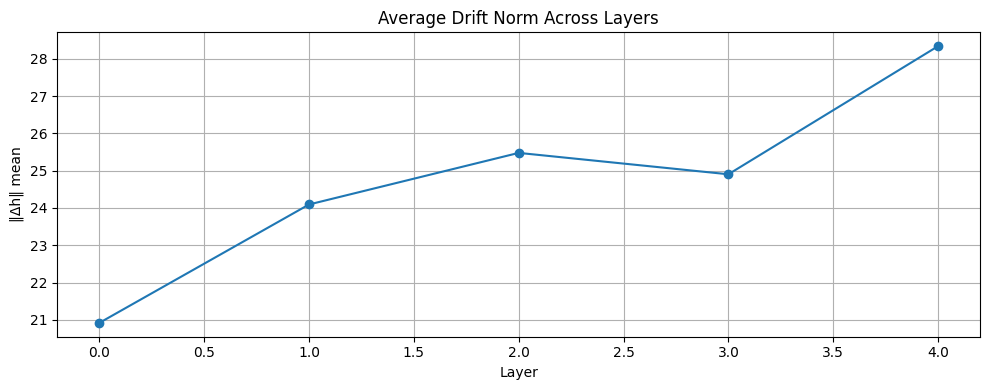

Jacobian rank (final token, projected): 66


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx
    # forward the GPT model itself


    # token + pos emb
    x = model.transformer.wte(tok)
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = m=norm(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, x.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


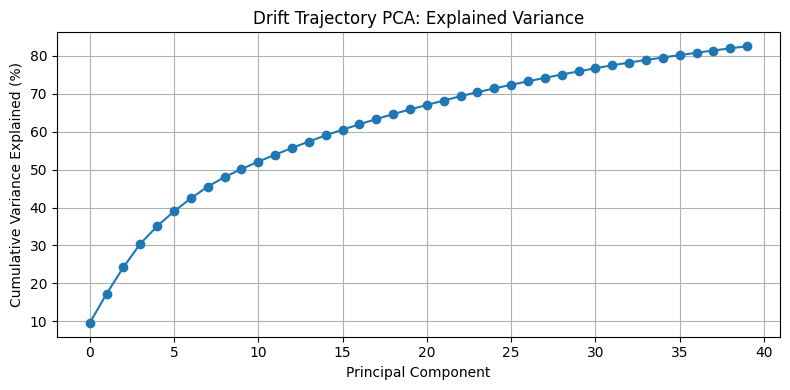

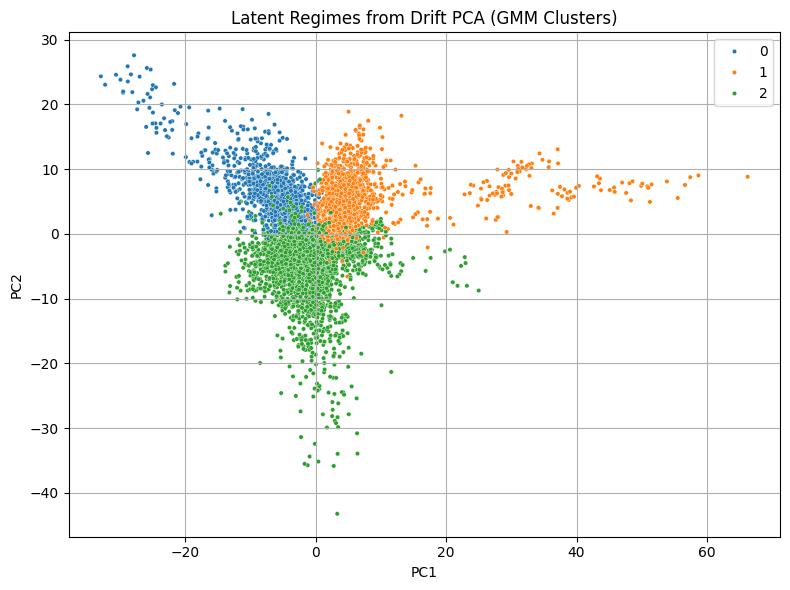

In [ ]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=3)
plot_gmm_clusters(proj, labels)


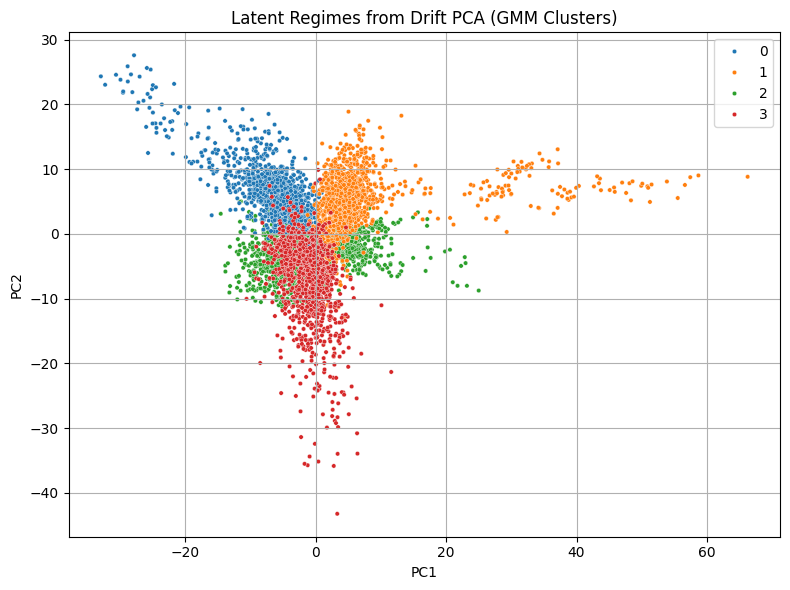

In [ ]:

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)

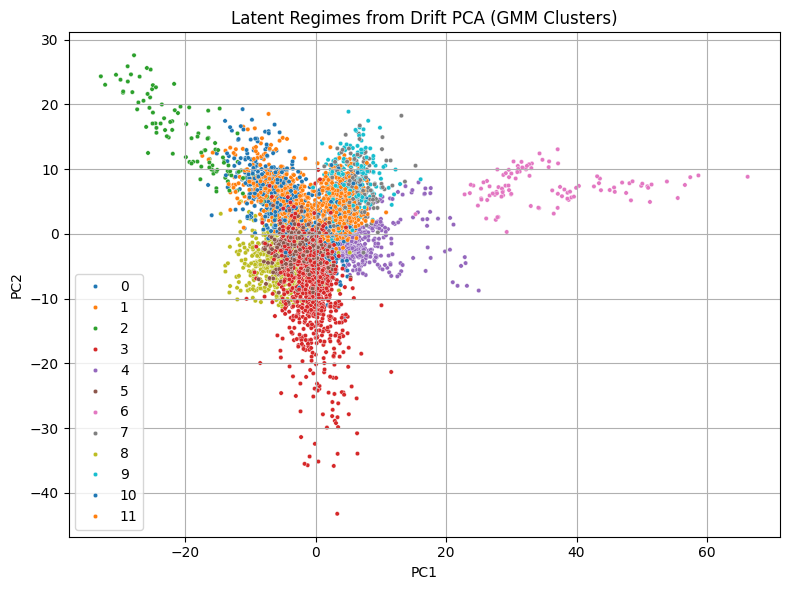

In [ ]:

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=12)
plot_gmm_clusters(proj, labels)

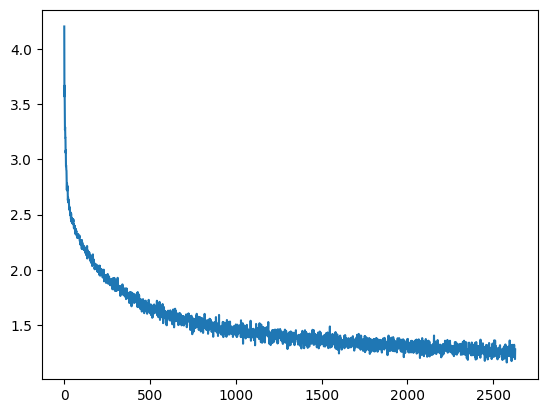

In [ ]:
plt.plot(losses)

/usr/local/lib/python3.12/site-packages/torch/_inductor/lowering.py:7095: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


[Baseline] Val loss: 1.5808

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 1.5296 | Δ = -0.0512
Ablate Layer  1: Loss = 1.5302 | Δ = -0.0506
Ablate Layer  2: Loss = 1.5797 | Δ = -0.0011


W0112 20:08:32.929000 82 site-packages/torch/_dynamo/convert_frame.py:1016] [0/9] torch._dynamo hit config.recompile_limit (8)
W0112 20:08:32.929000 82 site-packages/torch/_dynamo/convert_frame.py:1016] [0/9]    function: 'forward' (/tmp/ipykernel_82/702040264.py:323)
W0112 20:08:32.929000 82 site-packages/torch/_dynamo/convert_frame.py:1016] [0/9]    last reason: 0/8: ___check_obj_id(self._modules['transformer']._modules['h']._modules['3'].forward.__code__, 47333746853456)
W0112 20:08:32.929000 82 site-packages/torch/_dynamo/convert_frame.py:1016] [0/9] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0112 20:08:32.929000 82 site-packages/torch/_dynamo/convert_frame.py:1016] [0/9] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Ablate Layer  3: Loss = 1.5744 | Δ = -0.0064
Ablate Layer  4: Loss = 1.6258 | Δ = 0.0449
Ablate Layer  5: Loss = 1.5764 | Δ = -0.0045


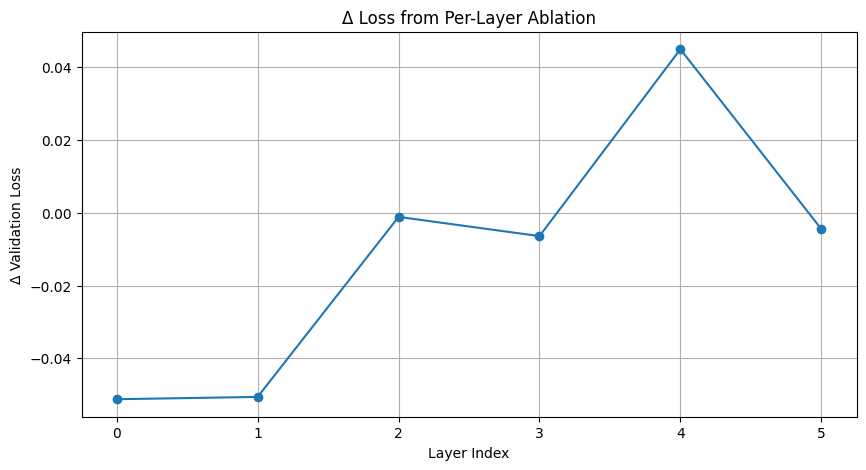

In [ ]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = model.config.block_size
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


In [ ]:
PATH = "model_weights.pth"

# Save only the model's learned parameters
torch.save(model.state_dict(), PATH)